In [112]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import GPy 

In [151]:
npts = 500
xv = np.linspace(-4., 4., npts)
x = xv[:, None]

### Regularity

In [152]:
kRBF = GPy.kern.RBF(1) 
kEXP = GPy.kern.Exponential(1) 

In [153]:
nsamples = 3
mu = np.zeros((npts)) 

KRBF = kRBF.K(x, x)
yRBF = KRBF[:, 250]
ZRBF = np.random.multivariate_normal(mu, KRBF, nsamples)

KEXP = kEXP.K(x, x)
yEXP = KEXP[:, 250]
ZEXP = np.random.multivariate_normal(mu, KEXP, nsamples)

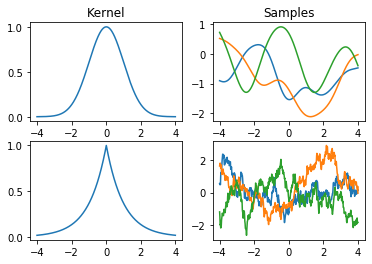

In [154]:
f, axes = plt.subplots(2, 2, sharey=False)
axes[0, 0].set_title('Kernel')
axes[0, 0].plot(x, yRBF) 
axes[1, 0].plot(x, yEXP)

axes[0, 1].set_title('Samples')
for i in range(nsamples):
    axes[0, 1].plot(x[:], ZRBF[i,:])
for i in range(nsamples):
    axes[1, 1].plot(x[:], ZEXP[i,:])
    
f.savefig('plots/regularity.eps', format='eps', dpi=300)

### Multiplication:

Change Points and Compact Support

In [155]:
def halfBump(x):
    e = np.piecewise(x, [x < 0, x >= 0], [lambda x: 0, lambda x: np.exp(-1/x)])
    return(e)

def bump(x, s):
    z = x**s
    f = halfBump(z) / (halfBump(z) + halfBump(1 - z))
    return(1 - f)

In [156]:
def sigmoid(x, a):
    return(1 / (1 + np.exp(-a*x)))

In [157]:
Kbump = np.zeros((npts, npts))
for i, a in enumerate(x):
    for j, b in enumerate(x): 
        Kbump[i, j] = bump(a, 2)*bump(b, 2)
        
KCS = np.multiply(KRBF, Kbump)

In [158]:
KSIG = np.zeros((npts, npts))
KSIGI = np.zeros((npts, npts))

for i, xv in enumerate(x):
    for j, yv in enumerate(x):
        KSIG[i, j] = sigmoid(xv, 1) * sigmoid(yv, 1)
        KSIGI[i, j] = (1 - sigmoid(xv, 1)) * (1 - sigmoid(yv, 1))
        
KCP = np.multiply(Ksig, KRBF) + np.multiply(KsigI, KEXP)

In [159]:
x.shape

(500, 1)

In [160]:
nsamples = 7

ZCS = np.random.multivariate_normal(mu, KCS, nsamples)
ZCP = np.random.multivariate_normal(mu, KCP, nsamples)

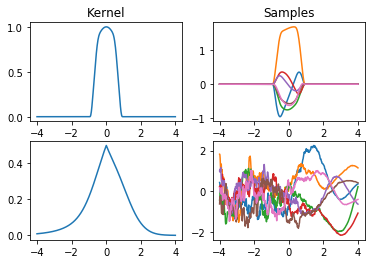

In [161]:
f, axes = plt.subplots(2, 2, sharey=False)
axes[0, 0].set_title('Kernel')
axes[0, 0].plot(x, KCS[250, :], label = '$k_{CS}$')
#axes[0, 0].legend()
axes[1, 0].plot(x, KCP[250, :])

axes[0, 1].set_title('Samples')
for i in range(nsamples):
    axes[0, 1].plot(x[:], ZCS[i,:])
for i in range(nsamples):
    axes[1, 1].plot(x[:], ZCP[i,:])

f.savefig('plots/multiply.eps', format='eps', dpi=300)

### Sum of Kernels:

Linear Periodic and Symmetric

In [162]:
kLIN = GPy.kern.Linear(input_dim = 1)
kPER = GPy.kern.PeriodicExponential(1, lengthscale=0.1, variance = 2, period = 3)
kSUM = kLIN + kPER

In [163]:
K1 = kEXP.K(x, x)
K2 = kEXP.K(-x, x)
KSYM = K1 + K2

nsamples = 3

In [164]:
KSUM = kSUM.K(x, x)
ZSUM = np.random.multivariate_normal(mu, KSUM, nsamples)

In [165]:
ZSYM = np.random.multivariate_normal(mu, KSYM, nsamples)

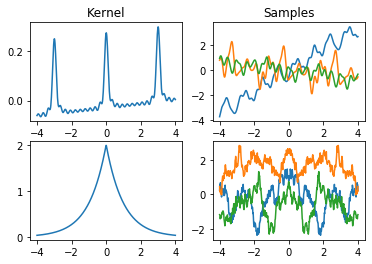

In [166]:
f, axes = plt.subplots(2, 2, sharey=False)
axes[0, 0].set_title('Kernel')
axes[0, 0].plot(x, KSUM[250, :], label = '$k_{CS}$')
#axes[0, 0].legend()
axes[1, 0].plot(x, KSYM[250, :])

axes[0, 1].set_title('Samples')
for i in range(nsamples):
    axes[0, 1].plot(x[:], ZSUM[i,:])
for i in range(nsamples):
    axes[1, 1].plot(x[:], ZSYM[i,:])

f.savefig('plots/sum.eps', format='eps', dpi=300)

### Div-Free

In [167]:
def divFreeKern(x, y, l):
    '''
    input: 
        - x and y two row vectors in R^n.
    output: 
        - k(x, y) div free kernel R^nxn matrix.
    '''
    #alphas usados en Wahlström: 0.3 , 1, 0.3
    alpha = 1 #o sigma como le llaman en otros libros
    n = len(x)
    
    xrf = matlib.repmat(x,n,1)
    xrc = xrf.T
    dxx1 = xrf-xrc
    dxx = dxx1**2
    
    yrf = matlib.repmat(y,n,1)
    yrc = yrf.T
    dyy1 = yrf - yrc
    dyy = dyy1**2
    
    dxy = dxx1 * dyy1

    t1 = (alpha**2)*np.e**(-1/2*(dxx+dyy)/l**2)    
    t1 = np.kron([[1,1],[1,1]],t1)
    
    t11 = 1/l**2-dyy/l**4
    t12 = dxy/l**4
    t22 = 1/l**2-dxx/l**4
    
    t2 = np.kron([[1,0],[0,0]],t11) + np.kron([[0,1],[1,0]],t12) + np.kron([[0,0],[0,1]],t22)
    K = t1*t2
        
    return(K)

In [168]:
def curlFreeKern(x, y, l):
    '''
    input: 
        - x and y two row vectors in R^n.
    output: 
        - k(x, y) div free kernel R^nxn matrix.
    '''
    
    #alphas usados en Wahlström: 0.3 , 1, 0.3
    alpha=0.3 #o sigma como le llaman en otros libros
    l=l#0.1
    n = len(x)
    
    xrf=np.matlib.repmat(x,n,1)
    xrc=xrf.T
    dxx1=xrf-xrc
    dxx=dxx1**2
    
    yrf=np.matlib.repmat(y,n,1)
    yrc=yrf.T
    dyy1=yrf-yrc
    dyy=dyy1**2
    
    z=np.zeros(n)
    zrf=np.matlib.repmat(z,n,1)
    zrc=zrf.T
    dzz1=zrf-zrc
    dzz=dzz1**2
    
    dxy=dxx1*dyy1
    dxz=dxx1*dzz1
    dyz=dyy1*dzz1

    #=np.array([[dyy,dxy],[dxy,dyy]])
    t1=(alpha**2)*np.e**(-1/2*(dxx+dyy+dzz)/l**2)
    t1=np.kron([[1,1,1],[1,1,1],[1,1,1]],t1)
    
    t11=np.kron([[1,0,0],[0,0,0],[0,0,0]], 1/l**2-dxx/l**4)
    t22=np.kron([[0,0,0],[0,1,0],[0,0,0]], 1/l**2-dyy/l**4)
    t33=np.kron([[0,0,0],[0,0,0],[0,0,1]], 1/l**2-dzz/l**4)
    t12=np.kron([[0,1,0],[1,0,0],[0,0,0]], -dxy/l**4)
    t13=np.kron([[0,0,1],[0,0,0],[1,0,0]], -dxz/l**4)
    t23=np.kron([[0,0,0],[0,0,1],[0,1,0]], -dyz/l**4)
    
    t2=t11+t22+t33+t12+t13+t23
    K=t1*t2
    
    return(K)

In [125]:
d = 2
nxGrid = 20

x = np.linspace(-2, 2., nxGrid)
y = np.linspace(-2, 2., nxGrid)
print(x.shape)

L = []
for i in range(nxGrid):
    for j in range(nxGrid):
        L.append([x[i], y[j]])

X = np.reshape(L, (nxGrid*nxGrid, d))

(20,)


In [173]:
l = 0.5
KDF = divFreeKern(X[:,0],X[:,1],l)
KCF = curlFreeKern(X[:,0],X[:,1],l)

In [177]:
muDF = np.zeros(d*nxGrid*nxGrid)
ZDF = np.random.multivariate_normal(muDF, KDF, 4)

muCF = np.zeros((d+1)*nxGrid*nxGrid)
ZCF = np.random.multivariate_normal(muCF, KCF, 4)

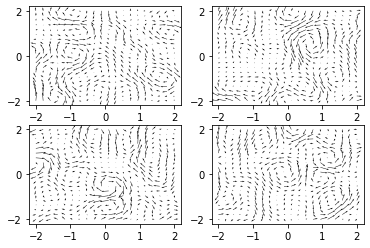

In [146]:
f, axes = plt.subplots(2, 2, sharey=False)
dx0 = ZDF[0][0:nxGrid*nxGrid]  
dy0 = ZDF[0][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz0 = ZDF[0][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

dx1 = ZDF[1][0:nxGrid*nxGrid]  
dy1 = ZDF[1][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz1 = ZDF[1][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

dx2 = ZDF[2][0:nxGrid*nxGrid]  
dy2 = ZDF[2][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz2 = ZDF[2][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

dx3 = ZDF[3][0:nxGrid*nxGrid]  
dy3 = ZDF[3][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz3 = ZDF[3][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

axes[0, 0].quiver(X[:,0], X[:,1], dx0, dy0)
axes[0, 1].quiver(X[:,0], X[:,1], dx1, dy1)
axes[1, 0].quiver(X[:,0], X[:,1], dx2, dy2)
axes[1, 1].quiver(X[:,0], X[:,1], dx3, dy3)

f.savefig('plots/div_free.eps', format='eps', dpi=300)

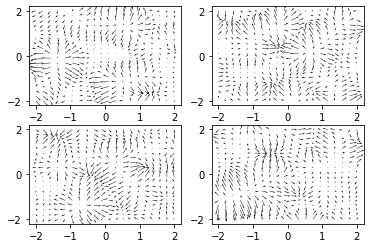

In [178]:
f, axes = plt.subplots(2, 2, sharey=False)
dx0 = ZCF[0][0:nxGrid*nxGrid]  
dy0 = ZCF[0][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz0 = ZCF[0][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

dx1 = ZCF[1][0:nxGrid*nxGrid]  
dy1 = ZCF[1][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz1 = ZCF[1][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

dx2 = ZCF[2][0:nxGrid*nxGrid]  
dy2 = ZCF[2][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz2 = ZCF[2][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

dx3 = ZCF[3][0:nxGrid*nxGrid]  
dy3 = ZCF[3][nxGrid*nxGrid:d*nxGrid*nxGrid] 
dz3 = ZCF[3][d*nxGrid*nxGrid:(d+1)*nxGrid*nxGrid]

axes[0, 0].quiver(X[:,0], X[:,1], dx0, dy0)
axes[0, 1].quiver(X[:,0], X[:,1], dx1, dy1)
axes[1, 0].quiver(X[:,0], X[:,1], dx2, dy2)
axes[1, 1].quiver(X[:,0], X[:,1], dx3, dy3)

f.savefig('plots/curl_free.eps', format='eps', dpi=300)